# Quantum Gate calibration using Model Free Reinforcement Learning

We extend the state preparation scheme to a gate calibration scheme by providing multiple input states to the target.

In [1]:
import numpy as np
from rl_qoc import QuantumEnvironment
from rl_qoc.helpers.tf_utils import select_optimizer, generate_model
from rl_qoc import (
    QiskitConfig,
    QEnvConfig,
    BenchmarkConfig,
    ExecutionConfig,
)

# Qiskit imports for building RL environment (circuit level)
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CXGate, XGate
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from typing import Optional

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag
from gymnasium.spaces import Box, Discrete

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Cod

In [2]:
# Ansatz function, could be at pulse level or circuit level
def apply_parametrized_circuit(
    qc: QuantumCircuit,
    params: Optional[ParameterVector],
    qr: Optional[QuantumRegister],
    n_actions: Optional[int] = None,
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    if params is None:
        try:
            params = ParameterVector("theta", n_actions)
        except TypeError:
            raise ValueError(
                "If params is None, n_actions should be provided to generate a ParameterVector"
            )
    if qr is None:
        qr = qc.qregs[0]
    param_circ = QuantumCircuit(qr)
    param_circ.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], qr[0])
    param_circ.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], qr[1])
    param_circ.rzx(2 * np.pi * params[6], 0, qr[1])
    qc.append(param_circ.to_instruction(), qr)

# Defining the QuantumEnvironment

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we can choose to go through the use of Qiskit Runtime, or to speed things up by using the local CPU and a state-vector simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```physical_qubits```: List of qubit indices which are specifically addressed by controls , namely the ones for which we intend to calibrate a gate upon or steer them in a specific quantum state. Note that this list could include less qubits than the total number of qubits, which can be useful when one wants to take into account crosstalk effects emerging from nearest-neighbor coupling.
- ```sampling_Paulis```: number of Pauli observables to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multi-qubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled). The more shots, the more accurate the estimation of the expectation value of the Pauli operator will be. Note that this number will be eventually multiplied by the number of times each Pauli observable was sampled through the ```sampling_Paulis``` parameter.
- The dimension of the action vector: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit.
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment.
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible by using resources of another module of Qiskit called Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"circuit"```. Another notebook at the pulse level is available in the repo. The abstraction level is inferred automatically from the provided ansatz function.

In [3]:
qubit_tgt_register = [0, 1]  # Choose which qubits of the QPU you want to address
sampling_Paulis = 300
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector
batchsize = (
    100  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
)
n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
action_space = Box(low=-1, high=1, shape=(n_actions,), dtype=np.float32)
observation_space = Box(low=0, high=1, shape=(1,), dtype=np.float32)
seed = 4030
estimator_options = {"seed_simulator": seed, "resilience_level": 0}

Choose below which IBM Backend to use. As we are dealing with circuit level implementation, we can look for a backend supporting Qiskit Runtime (could be a cloud simulator, or real backend) or simply set backend to None and rely on the Estimator primitive based on statevector simulation. In either case, we need access to one Estimator primitive to run the algorithm, as the feedback from the measurement outcomes is done by calculating Pauli expectation values.

## 1. Setting up a Quantum Backend

### Real backend initialization

Uncomment the cell below to declare a Qiskit Runtime backend. You need an internet connection and an IBM Id account to access this.

In [4]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend,
where Qiskit Runtime is enabled
"""

backend_name = "ibm_perth"

# service = QiskitRuntimeService(channel='ibm_quantum')
# runtime_backend = service.get_backend(backend_name)
# estimator_options = {'resilience_level': 0}

### Simulation backend initialization
If you want to run the algorithm over a simulation, you can use Qiskit BaseEstimator, which does not need any real backend and relies on statevector simulation.

Note that you could also define a custom Aer noise model and use an Aer version of the Estimator primitive. This feature will become available soon.


In [5]:
"""
If using Qiskit native Estimator primitive
(statevector simulation)
"""

no_backend = None

### Choose backend and define Qiskit config dictionary
Below, set the Backend that you would like to run among the above defined backend.
Then define the config gathering all the components enabling the definition of the ```QuantumEnvironment```.



In [6]:
backend = no_backend

In [7]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = QiskitConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    primitive_options=estimator_options,
    parametrized_circuit_kwargs={"n_actions": n_actions},
)

## 2. Define quantum target: State preparation or Gate calibration

The target of our optimal control task can be of two different types:
1.  An arbitrary quantum state to prepare with high accuracy
2. A Quantum Gate to be calibrated in a noise-robust manner

Both targets are dictionaries that are identified with a key stating their ```target_type```, which can be either ```"state"``` or ```"gate"```.

For a gate target $G$, one can add the target quantum gate with a ```"gate"``` argument specifying a specific instance of a Qiskit ```Gate``` object. Here, we settle for calibrating a ```CXGate()```.
Moreover, a gate calibration requires a set of input states $\{|s_i\rangle \}$ to be provided, such that the agent can try to set the actions such that the fidelity between the anticipated ideal target state (calculated as  $G|s_i\rangle$) and the output state are simultaneously maximized. To ensure a correlation between the average reward computed from the measurement outcomes and the average gate fidelity, the provided set of input states must be tomographically complete.

For a state target, one can provide, similarly to an input state, an ideal circuit to prepare it (```"circuit": QuantumCircuit```, or a density matrix (key ```"dm": DensityMatrix```).

Another important key that should figure in the dictionary is the ```"register"``` indicating the qubits indices that should be addressed by this target, i.e. upon which qubits should the target be engineered.


In [8]:
# Target gate: CNOT gate
cnot_target = {"gate": CXGate(), "physical_qubits": qubit_tgt_register}

In [9]:
target = cnot_target

## 3. Declare QuantumEnvironment object
Running the box below declares the QuantumEnvironment instance.


In [10]:
# Define quantum environment
execution_config = ExecutionConfig(
    n_shots=N_shots,
    batch_size=batchsize,
    n_reps=1,  # Number of times the gate is repeated
    sampling_paulis=sampling_Paulis,
    seed=seed,
    c_factor=1.0,  # Cost factor for the reward function
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=Qiskit_setup,
    action_space=action_space,
    execution_config=execution_config,
    benchmark_config=BenchmarkConfig(1)
)
q_env = QuantumEnvironment(training_config=q_env_config)

# Defining the RL agent: PPO

In [11]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""

%time

n_epochs = 1000  # Number of epochs

opti = "Adam"  # Optimizer choice
eta = 0.001  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.2  # Parameter for clipping value (PPO)
grad_clip = 0.03
critic_loss_coeff = 0.5
optimizer = select_optimizer(
    lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2
)
sigma_eps = 1e-3  # for numerical stability

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 1.67 μs


In [12]:
"""
-----------------------------------------------------------------------------------------------------
Policy parameters
-----------------------------------------------------------------------------------------------------
"""

N_in = observation_space.shape[
    -1
]  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [20, 20, 30]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros(N_in
)  # Here no feedback involved, so measurement sequence is always the same

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 20)           40          input_1[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 20)           420         hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           630         hidden_1[0][0]                   
______________________________________________________________________________________________

## Run algorithm

In [13]:
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 20
%matplotlib inline

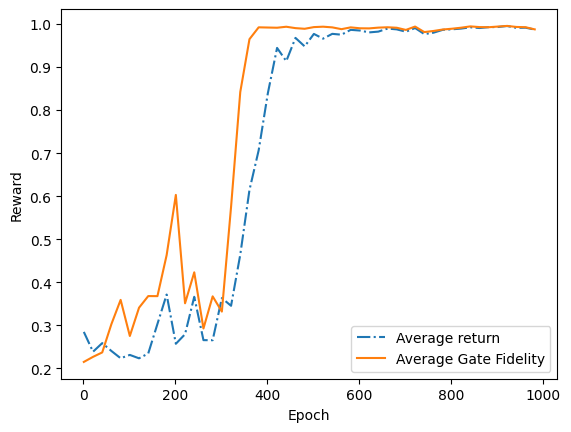

Maximum fidelity reached so far: 0.9966846662173758 at Epoch 915


 98%|█████████▊| 982/1000 [01:15<00:01, 12.71it/s]

Starting simulation benchmark...
Avg gate fidelity: [0.9881829144225872]
Finished simulation benchmark
Reward (avg): 0.9877223195246395 Std: 0.002776211355116738
Gate Fidelity 0.9881829144225872
Starting simulation benchmark...
Avg gate fidelity: [0.9862383802373191]
Finished simulation benchmark
Reward (avg): 0.9880891893607636 Std: 0.0036984049776845095
Gate Fidelity 0.9862383802373191
Starting simulation benchmark...
Avg gate fidelity: [0.9863783269097816]
Finished simulation benchmark
Reward (avg): 0.9879876393444157 Std: 0.002045700532553179
Gate Fidelity

 99%|█████████▊| 986/1000 [01:16<00:01, 13.48it/s]

 0.9863783269097816
Starting simulation benchmark...
Avg gate fidelity: [0.9856610654559287]
Finished simulation benchmark
Reward (avg): 0.98650013920496 Std: 0.003918695514495589
Gate Fidelity 0.9856610654559287
Starting simulation benchmark...
Avg gate fidelity: [0.9859726092938059]
Finished simulation benchmark
Reward (avg): 0.9870470499552009 Std: 0.0028744277117157767
Gate Fidelity 0.9859726092938059
Starting simulation benchmark...
Avg gate fidelity: [0.9845739924163865]
Finished simulation benchmark
Reward (avg): 0.9862277637225874 Std: 0.0022551754189420706


 99%|█████████▉| 988/1000 [01:16<00:00, 13.79it/s]

Gate Fidelity 0.9845739924163865
Starting simulation benchmark...
Avg gate fidelity: [0.9848383238781467]
Finished simulation benchmark
Reward (avg): 0.9870459222571357 Std: 0.002146663383333505
Gate Fidelity 0.9848383238781467
Starting simulation benchmark...
Avg gate fidelity: [0.9840108305282333]
Finished simulation benchmark
Reward (avg): 0.9860359092975286 Std: 0.0027207035744021913
Gate Fidelity 0.9840108305282333
Starting simulation benchmark...
Avg gate fidelity: [0.9847068792717668]
Finished simulation benchmark
Reward (avg): 0.9857352067551932 Std: 0.004872864759259351


 99%|█████████▉| 990/1000 [01:16<00:00, 13.83it/s]

Gate Fidelity 0.9847068792717668
Starting simulation benchmark...
Avg gate fidelity: [0.9843026421900742]
Finished simulation benchmark
Reward (avg): 0.9859909778827783 Std: 0.0038974608839104884
Gate Fidelity 0.9843026421900742
Starting simulation benchmark...
Avg gate fidelity: [0.9858426389055579]
Finished simulation benchmark
Reward (avg): 0.986228985799479 Std: 0.0029581345201283226


 99%|█████████▉| 992/1000 [01:16<00:00, 13.79it/s]

Gate Fidelity 0.9858426389055579
Starting simulation benchmark...
Avg gate fidelity: [0.9852660233641345]
Finished simulation benchmark
Reward (avg): 0.9874600259482267 Std: 0.0036049521597145326


 99%|█████████▉| 994/1000 [01:16<00:00, 13.98it/s]

Gate Fidelity 0.9852660233641345
Starting simulation benchmark...
Avg gate fidelity: [0.9858433732692463]
Finished simulation benchmark
Reward (avg): 0.9817838692739771 Std: 0.0038452379262796724
Gate Fidelity 0.9858433732692463
Starting simulation benchmark...
Avg gate fidelity: [0.986008087732112]
Finished simulation benchmark
Reward (avg): 0.9868764535255294 Std: 0.0019497416003578045
Gate Fidelity 0.986008087732112
Starting simulation benchmark...
Avg gate fidelity: [0.9871602317801382]
Finished simulation benchmark
Reward (avg): 0.988442616216554 Std: 0.0032566152405543395


100%|█████████▉| 996/1000 [01:16<00:00, 14.00it/s]

Gate Fidelity 0.9871602317801382
Starting simulation benchmark...
Avg gate fidelity: [0.9871926303422223]
Finished simulation benchmark
Reward (avg): 0.984678186639994 Std: 0.002796435471614345
Gate Fidelity 0.9871926303422223
Starting simulation benchmark...
Avg gate fidelity: [0.9881427616252937]
Finished simulation benchmark
Reward (avg): 0.9897084512707258 Std: 0.0025507172069233635


100%|█████████▉| 998/1000 [01:16<00:00, 14.10it/s]

Gate Fidelity 0.9881427616252937
Starting simulation benchmark...
Avg gate fidelity: [0.9880320199401394]
Finished simulation benchmark


100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]

Reward (avg): 0.989815861688478 Std: 0.002575374405718858
Gate Fidelity 0.9880320199401394
Starting simulation benchmark...
Avg gate fidelity: [0.9883952441948946]
Finished simulation benchmark
Reward (avg): 0.9903750659519891 Std: 0.0024386438506361265
Gate Fidelity 0.9883952441948946


In [14]:
"""
-----------------------------------------------------------------------------------------------------
Training loop
-----------------------------------------------------------------------------------------------------
"""

# TODO: Use TF-Agents PPO Agent
mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

for i in tqdm(range(n_epochs)):
    Old_distrib = MultivariateNormalDiag(
        loc=mu_old, scale_diag=sigma_old, validate_args=True, allow_nan_stats=False
    )
    obs, _ = q_env.reset()
    with tf.GradientTape(persistent=True) as tape:
        mu, sigma, b = network(obs, training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)

        Policy_distrib = MultivariateNormalDiag(
            loc=mu, scale_diag=sigma, validate_args=True, allow_nan_stats=False
        )

        action_vector = tf.stop_gradient(
            tf.clip_by_value(Policy_distrib.sample(batchsize), -1.0, 1.0)
        )
        # Update policy for benchmarking on env
        q_env.mean_action = np.array(mu)
        q_env.std_action = np.array(sigma)

        _, reward, _, _, _ = q_env.step(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (
                tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-6
            )
            actor_loss = -tf.reduce_mean(
                tf.minimum(
                    advantage * ratio,
                    advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon),
                )
            )
        else:  # REINFORCE algorithm
            actor_loss = -tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage**2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)
    if q_env.do_benchmark():
        avg_return[i] = np.mean(q_env.reward_history, axis=1)[i]
        fidelities[i] = q_env.avg_fidelity_history[i]
    print("Gate Fidelity", fidelities[i])
    if i % visualization_steps == 0:
        clear_output(wait=True)  # for animation
        fig, ax = plt.subplots()
        ax.plot(
            np.arange(1, n_epochs, 20),
            avg_return[0:-1:visualization_steps],
            "-.",
            label="Average return",
        )
        ax.plot(
            np.arange(1, n_epochs, 20),
            fidelities[0:-1:visualization_steps],
            label="Average Gate Fidelity",
        )
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Reward")
        ax.legend()
        plt.show()
        print(
            "Maximum fidelity reached so far:",
            np.max(fidelities),
            "at Epoch",
            np.argmax(fidelities),
        )

    # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
q_env.close()

In [17]:
print("Maximum fidelity reached:", np.max(fidelities), "at Epoch ", np.argmax(fidelities))
print(
    "Actions yielding optimal fidelity:",
   q_env.optimal_action,
)

Maximum fidelity reached: 0.9966846662173758 at Epoch  915
Actions yielding optimal fidelity: [-0.0193619  -0.6209393   0.87501657  0.2546456  -0.25052294  0.25247526
 -0.25100243]
